# A foodie in Rotterdam - finding her a home through machine learning

## Table of contents

- [0. Introduction](#0)
- [1. Data preparation](#1)
- [2. Plotting Rotterdam's neighborhoods](#2)
- [3. Looking for sushi on Foursquare](#3)
- [4. Discovering the top venues](#4)
- [5. Clustering with k-means](#5)
- [6. Mapping the clusters](#6)
- [7. Examining the clusters](#7)
- [8. Conclusion](#8)

## <a id='0'>0. Introduction</a>

For my master's studies, I lived in Rotterdam (NL) for over a year. Recently, a friend of mine who intends to move there soon, asked me which neighborhoods are the best for a person who loves sushi. She eats out a couple of times a week and she really cannot go without her weekly dose of sushi. So it is key for her to live in a neighborhood offering the possibility to quickly buy it on the way home from work. 

To solve this problem, I decided to make use of the Foursquare API to retrieve a list of places preparing sushi and to cluster my results to obtain a list of neighborhoods to propose to my friend.

There are several clustering methods available on Python but due to familiarity with it I went for the *k*-means method. It is an unsupervised machine learning technique, meaning the algorithm looks for previously undetected patterns in an unlabeled data set with little to no human supervision. The goal of the *k*-means method is to create a set of clusters with the lowest internal variance.

I learned how to use the Foursquare API and *k*-means clustering as part of the Capstone Project for the IBM Data Science Professional Certification, so part of the credits for the script definitely go to the authors of the course ;)

## <a id='1'>1. Data preparation</a>

Importing the libraries:

In [83]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Importing the data from an excel file containing the list of Rotterdam's neighborhoods:

In [212]:
#creating a dataframe with list of neighbourhoods
df = pd.read_excel("rott_neighborhoods.xlsx")

df.head()

,CBS-buurtcode,Buurtnaam
0,BU05990110,Stadsdriehoek
1,BU05990111,Oude Westen
2,BU05990112,Cool
3,BU05990113,CS-kwartier
4,BU05990118,Nieuwe Werk


Let's fix the dataframe:

In [213]:
#renaming the column

df["Neighborhood"]= df["Buurtnaam"]

df.head()

,CBS-buurtcode,Buurtnaam,Neighborhood
0,BU05990110,Stadsdriehoek,Stadsdriehoek
1,BU05990111,Oude Westen,Oude Westen
2,BU05990112,Cool,Cool
3,BU05990113,CS-kwartier,CS-kwartier
4,BU05990118,Nieuwe Werk,Nieuwe Werk


In [214]:
df= df.drop("Buurtnaam", axis=1)

df.head()

,CBS-buurtcode,Neighborhood
0,BU05990110,Stadsdriehoek
1,BU05990111,Oude Westen
2,BU05990112,Cool
3,BU05990113,CS-kwartier
4,BU05990118,Nieuwe Werk


I get the coordinates for the neighborhoods using geopy:

In [215]:
#getting the coordinates

locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode("Rotterdam")

from geopy.extra.rate_limiter import RateLimiter

# settin the function to create delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# inserting a location column
df['Location'] = df['Neighborhood'].apply(geocode)
# creating longitude, laatitude and altitude from location column (returns tuple)
df['point'] = df['Location'].apply(lambda loc: tuple(loc.point) if loc else None)
# splitting the point column into latitude, longitude and altitude columns
df[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

In [216]:
df.head()

,CBS-buurtcode,Neighborhood,Location,point,Latitude,Longitude,Altitude
0,BU05990110,Stadsdriehoek,"(Stadsdriehoek, Rotterdam, Zuid-Holland, Neder...","(51.9217682, 4.4866893, 0.0)",51.921768,4.486689,0.0
1,BU05990111,Oude Westen,"(Oude Westen, Centrum, Rotterdam, Zuid-Holland...","(51.9180447, 4.4662523, 0.0)",51.918045,4.466252,0.0
2,BU05990112,Cool,"(Cool, Parker County, Texas, United States of ...","(32.8001288, -98.001153, 0.0)",32.800129,-98.001153,0.0
3,BU05990113,CS-kwartier,"(CS-Kwartier, Kruisplein, Oude Westen, Centrum...","(51.924381049999994, 4.467433674506594, 0.0)",51.924381,4.467434,0.0
4,BU05990118,Nieuwe Werk,"(Nieuwe Werk, Centrum, Rotterdam, Zuid-Holland...","(51.9093549, 4.4774276, 0.0)",51.909355,4.477428,0.0


Let's see what I have inside the dataframe:

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CBS-buurtcode  90 non-null     object 
 1   Neighborhood   90 non-null     object 
 2   Location       88 non-null     object 
 3   point          88 non-null     object 
 4   Latitude       88 non-null     float64
 5   Longitude      88 non-null     float64
 6   Altitude       88 non-null     float64
dtypes: float64(3), object(4)
memory usage: 5.0+ KB


There seem to be 2 missing values, I'd better check further:

In [218]:
missing_data = df.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

CBS-buurtcode
False    90
Name: CBS-buurtcode, dtype: int64

Neighborhood
False    90
Name: Neighborhood, dtype: int64

Location
False    88
True      2
Name: Location, dtype: int64

point
False    88
True      2
Name: point, dtype: int64

Latitude
False    88
True      2
Name: Latitude, dtype: int64

Longitude
False    88
True      2
Name: Longitude, dtype: int64

Altitude
False    88
True      2
Name: Altitude, dtype: int64



I miss indeed location data for two neighborhoods. As it might be due to wrong spelling of the neighborhoods' names, let's check which ones did not match with the geopy:

In [219]:
df[pd.isnull(df["Location"])]

,CBS-buurtcode,Neighborhood,Location,point,Latitude,Longitude,Altitude
85,BU05992459,Bedrijventerrein Rotterdam Noord-West,None,None,NaN,NaN,NaN
87,BU05992650,Bedrijventerrein Schieveen,None,None,NaN,NaN,NaN


Better to reimport the data and start from scratch by substituting those names before getting the coordinates:

In [2]:
#let's reimport the data set 

df= pd.read_excel("rott_neighborhoods.xlsx")

df.head()

,CBS-buurtcode,Buurtnaam
0,BU05990110,Stadsdriehoek
1,BU05990111,Oude Westen
2,BU05990112,Cool
3,BU05990113,CS-kwartier
4,BU05990118,Nieuwe Werk


In [3]:
#fix some stuff

df["Neighborhood"] = df["Buurtnaam"]

df= df.drop(["Buurtnaam", "CBS-buurtcode"], axis=1)

df.head()

,Neighborhood
0,Stadsdriehoek
1,Oude Westen
2,Cool
3,CS-kwartier
4,Nieuwe Werk


In [4]:
# now change the names we found were wrong at 85 and 87

#drop 85

df = df.drop(85, axis=0)

In [5]:
#append two new rows

df2= pd.DataFrame([["Noord"], ["West"]], columns= ['Neighborhood'])
df= df.append(df2, ignore_index=True)

df.tail()

,Neighborhood
86,Bedrijventerrein Schieveen
87,Rozenburg
88,Noordzeeweg
89,Noord
90,West


In [6]:
#let's change the name of what became row 86

df.at[86, "Neighborhood"]= "Schieveen"

df.at[86, "Neighborhood"]

'Schieveen'

In [7]:
df.tail()

,Neighborhood
86,Schieveen
87,Rozenburg
88,Noordzeeweg
89,Noord
90,West


Now that the names are fixed, I can load the geo coordinates again:

In [58]:
#getting the coordinates

locator = Nominatim(user_agent="myGeocoder")

from geopy.extra.rate_limiter import RateLimiter

# settin the function to create delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# inserting a location column
df['Location'] = df['Neighborhood'].apply(geocode)
# creating longitude, laatitude and altitude from location column (returns tuple)
df['point'] = df['Location'].apply(lambda loc: tuple(loc.point) if loc else None)
# splitting the point column into latitude, longitude and altitude columns
df[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

SyntaxError: invalid syntax (<ipython-input-58-78a8f42e9aa0>, line 3)

In [59]:
df.head()

,Neighborhood,Location,Latitude,Longitude,point,Altitude
0,Stadsdriehoek,"(Stadsdriehoek, Rotterdam, Zuid-Holland, Neder...",51.921768,4.486689,"(51.9217682, 4.4866893, 0.0)",0.0
1,Oude Westen,"(Oude Westen, Centrum, Rotterdam, Zuid-Holland...",51.918045,4.466252,"(51.9180447, 4.4662523, 0.0)",0.0
2,Cool,"(Cool, Parker County, Texas, United States of ...",32.800129,-98.001153,"(32.8001288, -98.001153, 0.0)",0.0
3,CS-kwartier,"(CS-Kwartier, Kruisplein, Oude Westen, Centrum...",51.924381,4.467434,"(51.924381049999994, 4.467433674506594, 0.0)",0.0
4,Nieuwe Werk,"(Nieuwe Werk, Centrum, Rotterdam, Zuid-Holland...",51.909355,4.477428,"(51.9093549, 4.4774276, 0.0)",0.0


In [60]:
#check again for null values

df[pd.isnull(df["Location"])]


,Neighborhood,Location,Latitude,Longitude,point,Altitude


No more null values this time!

In [61]:
#I would drop point and Altitude

df = df.drop(["point", "Altitude"], axis=1)

df.head()

,Neighborhood,Location,Latitude,Longitude
0,Stadsdriehoek,"(Stadsdriehoek, Rotterdam, Zuid-Holland, Neder...",51.921768,4.486689
1,Oude Westen,"(Oude Westen, Centrum, Rotterdam, Zuid-Holland...",51.918045,4.466252
2,Cool,"(Cool, Parker County, Texas, United States of ...",32.800129,-98.001153
3,CS-kwartier,"(CS-Kwartier, Kruisplein, Oude Westen, Centrum...",51.924381,4.467434
4,Nieuwe Werk,"(Nieuwe Werk, Centrum, Rotterdam, Zuid-Holland...",51.909355,4.477428


However, now I seem to have another "little" problem: some of the location data I got are not for Rotterdam! I need to see which ones must be revised:

In [13]:
df.tail()

,Neighborhood,Location,Latitude,Longitude
86,Schieveen,"(Schieveen, Buitenhof, Lelystad, Flevoland, Ne...",52.513931,5.527236
87,Rozenburg,"(Rozenburg, Rotterdam, Zuid-Holland, Nederland...",51.919103,4.227051
88,Noordzeeweg,"(Noordzeeweg, Noorderhoogebrug, Oude wijken, G...",53.239567,6.567855
89,Noord,"(Noord, Amsterdam, Noord-Holland, Nederland, 1...",52.401739,4.915352
90,West,"(Western, West Kenya, Kenya, (0.5090396, 34.57...",0.509040,34.573134


In [29]:
df.head(20)

,Neighborhood,Location,Latitude,Longitude
0,Stadsdriehoek,"(Stadsdriehoek, Rotterdam, Zuid-Holland, Neder...",51.921768,4.486689
1,Oude Westen,"(Oude Westen, Centrum, Rotterdam, Zuid-Holland...",51.918045,4.466252
2,Cool,"(Cool, Parker County, Texas, United States of ...",32.800129,-98.001153
3,CS-kwartier,"(CS-Kwartier, Kruisplein, Oude Westen, Centrum...",51.924381,4.467434
4,Nieuwe Werk,"(Nieuwe Werk, Centrum, Rotterdam, Zuid-Holland...",51.909355,4.477428
5,Dijkzigt,"(Dijkzigt, Centrum, Rotterdam, Zuid-Holland, N...",51.912436,4.471307
6,Delfshaven,"(Delfshaven, Schiedamseweg, Bospolder, Delfsha...",51.909995,4.445700
7,Bospolder,"(Bospolder, Delfshaven, Rotterdam, Zuid-Hollan...",51.908980,4.442782
8,Tussendijken,"(Tussendijken, Delfshaven, Rotterdam, Zuid-Hol...",51.913092,4.441788
9,Spangen,"(Pange, Metz, Moselle, Grand Est, France métro...",49.084583,6.358119


Since Rotterdam's latitude is around 51. something, we can sort the values to see how bad the situation is:

In [53]:
dfx= df.sort_values(by= "Latitude")

Seems pretty bad, I need to slice the data set based on values of latitude below 51.000000 and above 52.000000 (first attempt). It will make my list less insightful but will save me a lot of time otherwise spent compiling coordinates by hand.


In [63]:
dfx.reset_index(drop=True)

,Neighborhood,Location,Latitude,Longitude
0,Noordereiland,"(North Island / Te Ika-a-Māui, South Waikato D...",-38.003530,175.957853
1,West,"(Western, West Kenya, Kenya, (0.5090396, 34.57...",0.509040,34.573134
2,Cool,"(Cool, Parker County, Texas, United States of ...",32.800129,-98.001153
3,Strand en Duin,"(Duino / Devin, UTI Giuliana / Julijska MTU, F...",45.773392,13.604485
4,Spangen,"(Pange, Metz, Moselle, Grand Est, France métro...",49.084583,6.358119
...,...,...,...,...
86,Rijnpoort,"(Rijnpoort, Getsewoud, Nieuw-Vennep, Haarlemme...",52.279403,4.617819
87,Noord,"(Noord, Amsterdam, Noord-Holland, Nederland, 1...",52.401739,4.915352
88,Schieveen,"(Schieveen, Buitenhof, Lelystad, Flevoland, Ne...",52.513931,5.527236
89,Schieveen,"(Schieveen, Buitenhof, Lelystad, Flevoland, Ne...",52.513931,5.527236


In [69]:
#let's look for values below 51.000000

cond1= dfx["Latitude"] < 52.000000 
cond2 = dfx["Latitude"] > 51.000000

df = dfx[cond1 & cond2]

In [73]:
df= df.reset_index(drop= True)

In [74]:
df.head()

,Neighborhood,Location,Latitude,Longitude
0,Hoogvliet-Zuid,"(Hoogvliet, Zuid-Holland, Nederland, 3194WK, N...",51.865285,4.364111
1,Waalhaven-Zuid,"(Waalhaven Zuid, Vondelingenweg, Waalhaven, Ro...",51.871429,4.431826
2,Zuidwijk,"(Zuidwijk, Charlois, Zuid-Holland, Nederland, ...",51.872625,4.489609
3,Pendrecht,"(Pendrecht, Rotterdam, Zuid-Holland, Nederland...",51.872742,4.470025
4,Lombardijen,"(Lombardijen, Rotterdam, Zuid-Holland, Nederla...",51.877681,4.521090


In [76]:
df.shape

(77, 4)

Now out dataframe is good to go!

## <a id='2'>2. Plotting Rotterdam's neighborhoods</a>

To starti with, I need to find the centre of my map, hence the coordinates of Rotterdam:

In [77]:
#centering the map

address = 'Rotterdam, NL'

location = locator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Rotterdam are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Rotterdam are 51.9228934, 4.4631786.


Now I can plot the neighborhoods (click on the blue dots to read their names):

In [78]:
map_rott = folium.Map(
    location=[latitude, longitude],
    tiles='cartodbpositron',
    zoom_start=12,
)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rott)  
    
map_rott

## <a id='3'>3. Looking for sushi on Foursquare</a>

Foursquare is a popular social location service allowing users to explore venues all over the world. For this exercise, I will use the Foursquare API that makes it possible to leverage on Foursquare's database of locations. 

Before starting I will first store my Foursquare API's ID and token:

In [116]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


Now, I set some parameters:

In [80]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

query= "Sushi"

And define the following function:

In [81]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            query,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now, let's get our venues in a dataframe:

In [84]:
rott_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

Hoogvliet-Zuid
Waalhaven-Zuid
Zuidwijk
Pendrecht
Lombardijen
Wielewaal
Pernis
Groot-IJsselmonde
Botlek
Vondelingenplaat
Eemhaven
Zuidplein
Vreewijk
Carnisse
Oud-Charlois
Waalhaven
Heijplaat
Tarwewijk
Hillesluis
Beverwaard
Bloemhof
Katendrecht
Oud-IJsselmonde
Afrikaanderwijk
Schiemond
Bospolder
Nieuwe Werk
Feijenoord
Delfshaven
Nieuw-Mathenesse
Rivium
Kop van Zuid-Entrepot
De Esch
Dijkzigt
Tussendijken
Kralingse Veer
Nieuwe Westen
Witte Dorp
Oud-Mathenesse
Middelland
's-Gravenland
Oude Westen
Rozenburg 
Struisenburg
Stadsdriehoek
Kralingen-Oost
CS-kwartier
Kralingen-West
Blijdorpse Polder
Provenierswijk
Agniesebuurt
Spaanse Polder
Blijdorp
Prinsenland
Oud-Crooswijk
Bergpolder
Oude Noorden
Kleinpolder
Kralingse Bos
Nieuw-Crooswijk
Noord-Kethel
Liskwartier
Overschie
Hillegersberg-Noord
Europoort
Het Lage Land
Landzicht
Oosterflank
Hillegersberg-Zuid
Maasvlakte
Terbregge
Zestienhoven
Schiebroek
Molenlaankwartier
Ommoord
Zevenkamp
Nesselande


A look at the new dataframe and its shape:

In [85]:
print(rott_venues.shape)
rott_venues.head()

(25, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hoogvliet-Zuid,51.865285,4.364111,Goya ALL YOU CAN EAT,51.865458,4.357734,Japanese Restaurant
1,Zuidplein,51.886895,4.488327,Happy Mango,51.887828,4.492036,Sushi Restaurant
2,Katendrecht,51.900892,4.481372,Azura,51.904344,4.485323,Asian Restaurant
3,Katendrecht,51.900892,4.481372,Azura Sushi,51.904251,4.485244,Sushi Restaurant
4,Katendrecht,51.900892,4.481372,SoHo Restaurant & Lounge,51.904313,4.485175,Sushi Restaurant


I finally have a data set comprehensive of location data for both neighborhoods and the new list of venues.

## <a id='4'>4. Discovering the top venues</a>

I want to elaborate on the new data I gathered, so let's briefly explore the results:

In [93]:
# number of venues by neighborhood
rott_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agniesebuurt,1,1,1,1,1,1
CS-kwartier,2,2,2,2,2,2
Dijkzigt,1,1,1,1,1,1
Hillegersberg-Zuid,1,1,1,1,1,1
Hoogvliet-Zuid,1,1,1,1,1,1
Katendrecht,4,4,4,4,4,4
Kleinpolder,1,1,1,1,1,1
Kralingen-West,1,1,1,1,1,1
Liskwartier,1,1,1,1,1,1


In [94]:
print('There are {} uniques categories.'.format(len(rott_venues['Venue Category'].unique())))

There are 6 uniques categories.


In [95]:
print('The categories are {} .'.format(rott_venues['Venue Category'].unique()))

The categories are ['Sushi Restaurant' 'Asian Restaurant' 'Restaurant' 'Korean Restaurant'
 'Japanese Restaurant' 'Chinese Restaurant'] .


I now want to create a dataframe displaying the 6 top venues for each neighborhood.

In [86]:
# one hot encoding: dummy variables for each column
rott_onehot = pd.get_dummies(rott_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rott_onehot['Neighborhood'] = rott_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [rott_onehot.columns[-1]] + list(rott_onehot.columns[:-1])
rott_onehot = rott_onehot[fixed_columns]

rott_onehot.head()

,Neighborhood,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Restaurant,Sushi Restaurant
0,Hoogvliet-Zuid,0,0,1,0,0,0
1,Zuidplein,0,0,0,0,0,1
2,Katendrecht,1,0,0,0,0,0
3,Katendrecht,0,0,0,0,0,1
4,Katendrecht,0,0,0,0,0,1


In [87]:
#group the neighborhoods and see the results of the onehot encoding
rott_grouped = rott_onehot.groupby('Neighborhood').mean().reset_index()
rott_grouped

,Neighborhood,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Restaurant,Sushi Restaurant
0,Agniesebuurt,0.000000,0.00,0.0,0.000000,0.000000,1.0
1,CS-kwartier,0.000000,0.00,0.0,0.000000,0.000000,1.0
2,Dijkzigt,0.000000,0.00,1.0,0.000000,0.000000,0.0
3,Hillegersberg-Zuid,1.000000,0.00,0.0,0.000000,0.000000,0.0
4,Hoogvliet-Zuid,0.000000,0.00,1.0,0.000000,0.000000,0.0
5,Katendrecht,0.250000,0.25,0.0,0.000000,0.000000,0.5
6,Kleinpolder,0.000000,1.00,0.0,0.000000,0.000000,0.0
7,Kralingen-West,0.000000,0.00,0.0,0.000000,0.000000,1.0
8,Liskwartier,0.000000,0.00,1.0,0.000000,0.000000,0.0
9,Nesselande,0.000000,0.00,0.0,0.000000,0.000000,1.0


In [88]:
#setting my number of top venues I want to display
num_top_venues = 6


#defining the function and printing my top 6 venues by neighborhood
for hood in rott_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = rott_grouped[rott_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agniesebuurt----
                 venue  freq
0     Sushi Restaurant   1.0
1     Asian Restaurant   0.0
2   Chinese Restaurant   0.0
3  Japanese Restaurant   0.0
4    Korean Restaurant   0.0
5           Restaurant   0.0


----CS-kwartier----
                 venue  freq
0     Sushi Restaurant   1.0
1     Asian Restaurant   0.0
2   Chinese Restaurant   0.0
3  Japanese Restaurant   0.0
4    Korean Restaurant   0.0
5           Restaurant   0.0


----Dijkzigt----
                 venue  freq
0  Japanese Restaurant   1.0
1     Asian Restaurant   0.0
2   Chinese Restaurant   0.0
3    Korean Restaurant   0.0
4           Restaurant   0.0
5     Sushi Restaurant   0.0


----Hillegersberg-Zuid----
                 venue  freq
0     Asian Restaurant   1.0
1   Chinese Restaurant   0.0
2  Japanese Restaurant   0.0
3    Korean Restaurant   0.0
4           Restaurant   0.0
5     Sushi Restaurant   0.0


----Hoogvliet-Zuid----
                 venue  freq
0  Japanese Restaurant   1.0
1     Asian Re

In [93]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

I create the new dataframe I will fill in with data about the top venues

In [94]:
num_top_venues = 6

indicators = ['st', 'nd', 'rd','th','th','th']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = rott_grouped['Neighborhood']

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Agniesebuurt,NaN,NaN,NaN,NaN,NaN,NaN
1,CS-kwartier,NaN,NaN,NaN,NaN,NaN,NaN
2,Dijkzigt,NaN,NaN,NaN,NaN,NaN,NaN
3,Hillegersberg-Zuid,NaN,NaN,NaN,NaN,NaN,NaN
4,Hoogvliet-Zuid,NaN,NaN,NaN,NaN,NaN,NaN


I put in the data derived from the return_most_common_venues function:

In [95]:
#populate the df

for ind in np.arange(rott_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rott_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Agniesebuurt,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant
1,CS-kwartier,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant
2,Dijkzigt,Japanese Restaurant,Sushi Restaurant,Restaurant,Korean Restaurant,Chinese Restaurant,Asian Restaurant
3,Hillegersberg-Zuid,Asian Restaurant,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant
4,Hoogvliet-Zuid,Japanese Restaurant,Sushi Restaurant,Restaurant,Korean Restaurant,Chinese Restaurant,Asian Restaurant


## <a id='5'>5. Clustering with k-means</a>

I want to know the ideal number of clusters I should ask the algorithm to build, so I use the Elbow method:

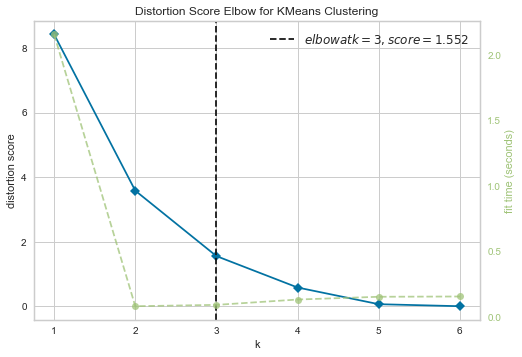

In [97]:
#import the modules
import matplotlib as mpl
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

#prepare the dataframe
rott_clustering= rott_grouped.drop("Neighborhood", 1)

#choose the model and set the visualizer
model= KMeans()
visualizer = KElbowVisualizer(model, k=(1,7))

#fit the data
visualizer.fit(rott_clustering)

#plot
visualizer.show()

To perform the elbow method, run several k-means are run incrementing k with each iteration, and the squared standard error (SSE, here distortion score) is recorded. The SSE declines the more k is incremented. The point where the blue line starts to bend is called elbow. That is the optimal number of clusters as it is supposed to be the right trade-off between error and number of clusters.

We now have the optimal number of clusters and can start building the clusters and analyzing them:

In [98]:
# set number of clusters
kclusters = 3
rott_clustering= rott_grouped.drop("Neighborhood", 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rott_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10].astype(int)

array([1, 1, 0, 2, 0, 2, 2, 1, 0, 1])

In [99]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

rott_merged = df

#add latitude/longitude for each neighborhood
rott_merged = rott_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

rott_merged.head() 

,Neighborhood,Location,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Hoogvliet-Zuid,"(Hoogvliet, Zuid-Holland, Nederland, 3194WK, N...",51.865285,4.364111,0.0,Japanese Restaurant,Sushi Restaurant,Restaurant,Korean Restaurant,Chinese Restaurant,Asian Restaurant
1,Waalhaven-Zuid,"(Waalhaven Zuid, Vondelingenweg, Waalhaven, Ro...",51.871429,4.431826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Zuidwijk,"(Zuidwijk, Charlois, Zuid-Holland, Nederland, ...",51.872625,4.489609,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Pendrecht,"(Pendrecht, Rotterdam, Zuid-Holland, Nederland...",51.872742,4.470025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lombardijen,"(Lombardijen, Rotterdam, Zuid-Holland, Nederla...",51.877681,4.521090,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# we merged the df with venues with the original df so many rows will contain null values

rott_merged[pd.isnull(rott_merged["Cluster Label"])].count() #if a row has no values in cluster label then we do not need it

Neighborhood             61
Location                 61
Latitude                 61
Longitude                61
Cluster Label             0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
dtype: int64

In [101]:
#just save a new df without null values

rott_merged= rott_merged.dropna()

Let's check the new shape of the dataframe:

In [102]:
rott_merged.shape

(16, 11)

## <a id='6'>6. Mapping the clusters</a>

I can finally start mapping the clusters:

In [103]:
# create map
map_clusters = folium.Map(location=[51.9180447, 4.4662523], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rott_merged['Latitude'], rott_merged['Longitude'], rott_merged['Neighborhood'], rott_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

TypeError: list indices must be integers or slices, not float

As there seems to be a problem with the data type let's check the info:

In [104]:
rott_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 76
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Neighborhood           16 non-null     object 
 1   Location               16 non-null     object 
 2   Latitude               16 non-null     float64
 3   Longitude              16 non-null     float64
 4   Cluster Label          16 non-null     float64
 5   1st Most Common Venue  16 non-null     object 
 6   2nd Most Common Venue  16 non-null     object 
 7   3rd Most Common Venue  16 non-null     object 
 8   4th Most Common Venue  16 non-null     object 
 9   5th Most Common Venue  16 non-null     object 
 10  6th Most Common Venue  16 non-null     object 
dtypes: float64(3), object(8)
memory usage: 1.5+ KB


I will adjust Cluster Label to be an integer instead of a float:

In [105]:
#changing cluster label to int

rott_merged["Cluster Label"]= rott_merged["Cluster Label"].astype("int")

In [106]:
rott_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 76
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Neighborhood           16 non-null     object 
 1   Location               16 non-null     object 
 2   Latitude               16 non-null     float64
 3   Longitude              16 non-null     float64
 4   Cluster Label          16 non-null     int32  
 5   1st Most Common Venue  16 non-null     object 
 6   2nd Most Common Venue  16 non-null     object 
 7   3rd Most Common Venue  16 non-null     object 
 8   4th Most Common Venue  16 non-null     object 
 9   5th Most Common Venue  16 non-null     object 
 10  6th Most Common Venue  16 non-null     object 
dtypes: float64(2), int32(1), object(8)
memory usage: 1.4+ KB


Now everything should be fixed, let's plot!

In [109]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='cartodbpositron')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(rott_merged['Latitude'], rott_merged['Longitude'], rott_merged['Neighborhood'], rott_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup= label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

By clicking on the points, we can check the meaning of the colors. Several venues are in the city centre and most of them seem to belong to cluster 1.

## <a id='7'>7. Examining the clusters</a>

It is the moment to inspect the content of our clusters and discover what will be the best proposal for my friend:

In [110]:
cluster_0 = rott_merged.loc[rott_merged['Cluster Label'] == 0, rott_merged.columns[[0] + list(range(5, rott_merged.shape[1]))]]

cluster_0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Hoogvliet-Zuid,Japanese Restaurant,Sushi Restaurant,Restaurant,Korean Restaurant,Chinese Restaurant,Asian Restaurant
33,Dijkzigt,Japanese Restaurant,Sushi Restaurant,Restaurant,Korean Restaurant,Chinese Restaurant,Asian Restaurant
56,Oude Noorden,Japanese Restaurant,Sushi Restaurant,Restaurant,Korean Restaurant,Chinese Restaurant,Asian Restaurant
61,Liskwartier,Japanese Restaurant,Sushi Restaurant,Restaurant,Korean Restaurant,Chinese Restaurant,Asian Restaurant


In [111]:
print("Cluster 0 contains the following neighborhoods:{}".format(cluster_0["Neighborhood"].unique()))
print("The most common type of venue in Cluster 0 is:{}".format(cluster_0["1st Most Common Venue"].unique()))

Cluster 0 contains the following neighborhoods:['Hoogvliet-Zuid' 'Dijkzigt' 'Oude Noorden' 'Liskwartier']
The most common type of venue in Cluster 0 is:['Japanese Restaurant']


In [112]:
cluster_1= rott_merged.loc[rott_merged['Cluster Label'] == 1, rott_merged.columns[[0] + list(range(5, rott_merged.shape[1]))]]

cluster_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
11,Zuidplein,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant
26,Nieuwe Werk,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant
41,Oude Westen,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant
46,CS-kwartier,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant
47,Kralingen-West,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant
49,Provenierswijk,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant
50,Agniesebuurt,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant
76,Nesselande,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant,Asian Restaurant


In [113]:
print("Cluster 1 contains the following neighborhoods:{}".format(cluster_1["Neighborhood"].unique()))
print("The most common type of venue in Cluster 1 is:{}".format(cluster_1["1st Most Common Venue"].unique()))

Cluster 1 contains the following neighborhoods:['Zuidplein' 'Nieuwe Werk' 'Oude Westen' 'CS-kwartier' 'Kralingen-West'
 'Provenierswijk' 'Agniesebuurt' 'Nesselande']
The most common type of venue in Cluster 1 is:['Sushi Restaurant']


In [114]:
cluster_2= rott_merged.loc[rott_merged['Cluster Label'] == 2, rott_merged.columns[[0] + list(range(5, rott_merged.shape[1]))]]

cluster_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
21,Katendrecht,Sushi Restaurant,Chinese Restaurant,Asian Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant
44,Stadsdriehoek,Sushi Restaurant,Restaurant,Korean Restaurant,Asian Restaurant,Japanese Restaurant,Chinese Restaurant
57,Kleinpolder,Chinese Restaurant,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Asian Restaurant
68,Hillegersberg-Zuid,Asian Restaurant,Sushi Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Chinese Restaurant


In [115]:
print("Cluster 2 contains the following neighborhoods:{}".format(cluster_2["Neighborhood"].unique()))
print("The most common type of venue in Cluster 2 is:{}".format(cluster_2["1st Most Common Venue"].unique()))

Cluster 2 contains the following neighborhoods:['Katendrecht' 'Stadsdriehoek' 'Kleinpolder' 'Hillegersberg-Zuid']
The most common type of venue in Cluster 2 is:['Sushi Restaurant' 'Chinese Restaurant' 'Asian Restaurant']


## <a id='8'>8. Conclusion</a>

According to my results, cluster 1 is the best proposal to my friend. Cluster 1 contains: Zuidplein, Nieuwe Werk, Oude Westen, CS-kwartier, Kralingen-West, Provenierswijk, Agniesebuurt, Nesselande. 
When looking for "sushi" on Foursquare, the most common venue for all cluster-1 neighborhoods is "Sushi Restaurant". If she wants to have sushi on the last-minute those are definitely the right neighborhoods to live in. 

The other two clusters should not be neglected either, as in both cases "Sushi Restaurant" still makes it above the top three venues. 